### NTM WS22
# Implementing the JPEG Compression Algorithm
#### Michael Mente 01634435, Lukas Pezzei 11834075, Julian Saria 01608505

In [1]:
from jpeg_implementation.dct import block_dct2, block_idct2
from jpeg_implementation.huffman import generate_huffman_code, encode_huffman, decode_huffman
from jpeg_implementation.quantization import quantize, quantize_inverse, \
    get_quantization_matrix_for_quality_percent
from jpeg_implementation.runLengthEncode import  resort_values_zig_zag, run_length_encode, flatten, resort_values_zig_zag_reverse, run_length_decode, un_flatten

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

In [2]:
# image which should be encoded
image_path = "images/lenna_32x32.png"

# jpeg parameters
block_size: int = 8
subsampling_settings: Tuple[int, int, int] = (4, 2, 0)  # can be (4,1,0), (4,1,1), (4,2,0), (4,2,2), (4,4,4)
quantization_table_quality: int = 50  # percentage of quantization quality 0..100

[[158 156 165 147  98 106 110 124]
 [157 159 164 144  95 105 108 122]
 [161 163 161 142  94 104 108 121]
 [165 139 161 145  90 101 108 121]
 [152 106 164 142  85 100 105 116]
 [109 105 164 141  87 100 105 117]
 [ 91 105 162 142  86  99 104 116]
 [ 91 103 161 142  83  98 104 122]]


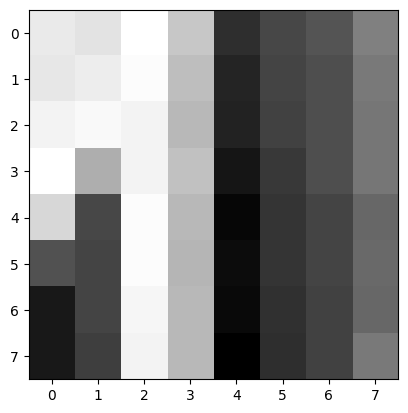

In [3]:
original_image = plt.imread(image_path)

# strip alpha channel if exists
if original_image.shape[2] == 4:
    channels = np.dsplit(original_image, 4)
    original_image = np.dstack(channels[:3])

# select only 8x8 matrix
original_image = original_image[:8, :8]
# convert to grayscale
original_image = np.dot(original_image[...,:3], [0.299, 0.587, 0.114])

# convert range from 0..1 to int (0..255)
original_image *= 255
original_image = np.rint(original_image)
original_image = original_image.astype(int)

fig, ax = plt.subplots()
ax.imshow(original_image, cmap="gray")
print(np.matrix(original_image))

## Step 4
### Apply dct

In [4]:
trans = block_dct2(original_image - 128, block_size)

data after dct:
 [[ 22.716  29.113  26.342  11.589 -44.815 -28.815  -9.226   4.734]
 [ 20.53   30.835  25.829   7.534 -48.093 -29.547 -10.505   3.943]
 [ 22.656  35.618  23.6     3.84  -48.818 -30.466 -10.235   3.203]
 [ 31.889  16.015  14.804  11.468 -52.689 -31.663  -8.349   4.183]
 [ 28.108 -18.873   8.607  16.374 -58.148 -29.66  -10.229   2.02 ]
 [-11.483 -33.224  15.697  17.038 -53.131 -27.986  -8.906   3.49 ]
 [-28.961 -38.285  16.25   17.834 -52.622 -28.813  -8.845   3.296]
 [-28.803 -39.434  14.458  18.613 -54.557 -27.923  -6.082   9.098]]


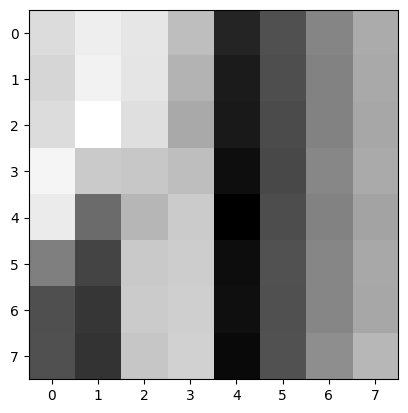

In [5]:
print("data after dct:\n", np.round(trans,3))
fig, ax = plt.subplots()
ax.imshow(trans, cmap="gray")
plt.show()

## Step 5
### Quantization


In [6]:
quantization_table = get_quantization_matrix_for_quality_percent(quantization_table_quality)

quantized = quantize([trans], quantization_table)

quantization_table (quality: 50%): 
 [[ 16  11  10  16  24  40  51  61]
 [ 12  12  14  19  26  58  60  55]
 [ 14  13  16  24  40  57  69  56]
 [ 14  17  22  29  51  87  80  62]
 [ 18  22  37  56  68 109 103  77]
 [ 24  35  55  64  81 104 113  92]
 [ 49  64  78  87 103 121 120 101]
 [ 72  92  95  98 112 100 103  99]]
data after quantization:
 [[ 1.  3.  3.  1. -2. -1. -0.  0.]
 [ 2.  3.  2.  0. -2. -1. -0.  0.]
 [ 2.  3.  1.  0. -1. -1. -0.  0.]
 [ 2.  1.  1.  0. -1. -0. -0.  0.]
 [ 2. -1.  0.  0. -1. -0. -0.  0.]
 [-0. -1.  0.  0. -1. -0. -0.  0.]
 [-1. -1.  0.  0. -1. -0. -0.  0.]
 [-0. -0.  0.  0. -0. -0. -0.  0.]]


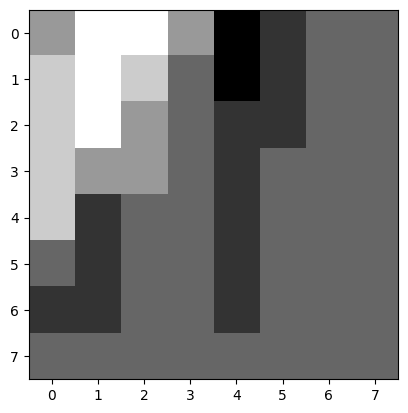

In [7]:
print(f"quantization_table (quality: {quantization_table_quality}%): \n", quantization_table)
print("data after quantization:\n", quantized[0])
fig, ax = plt.subplots()
ax.imshow(quantized[0], cmap="gray")
plt.show()

## Step 6 + 7
### Reordering of values, Run Length Encoding

In [8]:
resorted = resort_values_zig_zag(quantized, block_size)
encoded_blocks = run_length_encode(resorted)
rl_encoded = flatten(encoded_blocks)

print(encoded_blocks)
print(rl_encoded)

[(1.0, 1), (3.0, 1), (2.0, 2), (3.0, 2), (1.0, 1), (2.0, 1), (3.0, 1), (2.0, 2), (1.0, 2), (0.0, 1), (-2.0, 1), (-1.0, 1), (-2.0, 1), (0.0, 1), (1.0, 1), (-1.0, 1), (-0.0, 1), (-1.0, 2), (0.0, 2), (-1.0, 2), (-0.0, 3), (-1.0, 2), (0.0, 2), (-1.0, 1), (-0.0, 4), (-1.0, 1), (-0.0, 6), (-1.0, 1), (0.0, 3), (-1.0, 1), (-0.0, 13)]
[1.0, 1, 3.0, 1, 2.0, 2, 3.0, 2, 1.0, 1, 2.0, 1, 3.0, 1, 2.0, 2, 1.0, 2, 0.0, 1, -2.0, 1, -1.0, 1, -2.0, 1, 0.0, 1, 1.0, 1, -1.0, 1, -0.0, 1, -1.0, 2, 0.0, 2, -1.0, 2, -0.0, 3, -1.0, 2, 0.0, 2, -1.0, 1, -0.0, 4, -1.0, 1, -0.0, 6, -1.0, 1, 0.0, 3, -1.0, 1, -0.0, 13]


## Step 8
### Huffman Encoding

In [9]:
huffman_code = generate_huffman_code(rl_encoded)
huff_encoded = encode_huffman(huffman_code, rl_encoded)


In [10]:
print(huffman_code)
print(huff_encoded)

{3.0: '111', 4: '11011', 6: '11010', 13: '11001', -2.0: '11000', 2.0: '10', -1.0: '011', 0.0: '010', 1.0: '00'}
0000111001010111100000100011100101000100100011000000110011000000100000000110001000011100101001110010111011100101001100010110110110001011010011000101110110001011001


## Step 11
### Decode Huffman

In [11]:
rl_encoded = decode_huffman(huff_encoded, huffman_code)
print(rl_encoded)

[1.0, 1.0, 3.0, 1.0, 2.0, 2.0, 3.0, 2.0, 1.0, 1.0, 2.0, 1.0, 3.0, 1.0, 2.0, 2.0, 1.0, 2.0, 0.0, 1.0, -2.0, 1.0, -1.0, 1.0, -2.0, 1.0, 0.0, 1.0, 1.0, 1.0, -1.0, 1.0, 0.0, 1.0, -1.0, 2.0, 0.0, 2.0, -1.0, 2.0, 0.0, 3.0, -1.0, 2.0, 0.0, 2.0, -1.0, 1.0, 0.0, 4, -1.0, 1.0, 0.0, 6, -1.0, 1.0, 0.0, 3.0, -1.0, 1.0, 0.0, 13]


## Step 12 + 13
### Decode run-length encoding + Reordering of values

In [12]:
un_flattened = un_flatten(rl_encoded)
block_zig_zag = run_length_decode(un_flattened)
block = resort_values_zig_zag_reverse(block_zig_zag, block_size)

print(block)

[[ 1.  3.  3.  1. -2. -1.  0.  0.]
 [ 2.  3.  2.  0. -2. -1.  0.  0.]
 [ 2.  3.  1.  0. -1. -1.  0.  0.]
 [ 2.  1.  1.  0. -1.  0.  0.  0.]
 [ 2. -1.  0.  0. -1.  0.  0.  0.]
 [ 0. -1.  0.  0. -1.  0.  0.  0.]
 [-1. -1.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]


## Step 14
### Apply inverse quantization

data after inverse quantization:
 [[  16.   33.   30.   16.  -48.  -40.    0.    0.]
 [  24.   36.   28.    0.  -52.  -58.    0.    0.]
 [  28.   39.   16.    0.  -40.  -57.    0.    0.]
 [  28.   17.   22.    0.  -51.    0.    0.    0.]
 [  36.  -22.    0.    0.  -68.    0.    0.    0.]
 [   0.  -35.    0.    0.  -81.    0.    0.    0.]
 [ -49.  -64.    0.    0. -103.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]]


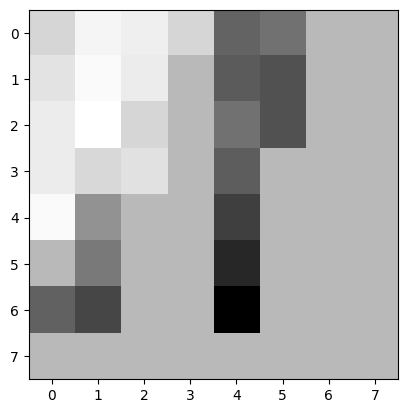

In [13]:
iq = quantize_inverse([block], quantization_table)
print("data after inverse quantization:\n", iq[0])
fig, ax = plt.subplots()
ax.imshow(iq[0], cmap="gray")
plt.show()

## Step 15
### Apply inverse DCT

In [14]:
inverse_dct = block_idct2(iq[0], block_size) + 128

data after inverse dct:
 [[152.53 162.15 167.21 154.91  94.09  95.43 117.74 120.3 ]
 [162.58 167.37 164.9  144.87  93.18  75.69 113.67 114.68]
 [168.25 165.3  151.18 146.64 102.02  77.72 115.22 115.87]
 [159.52 142.94 163.14 126.11  87.24 126.58 122.22 125.57]
 [159.7  100.   157.01 118.51  69.48 120.53 116.17 120.08]
 [123.01  97.75 155.66 117.74  54.04 118.45 111.03 116.77]
 [ 69.9   84.69 157.19 113.98  29.54 113.92 102.98 111.02]
 [128.   128.   128.   128.   128.   128.   128.   128.  ]]


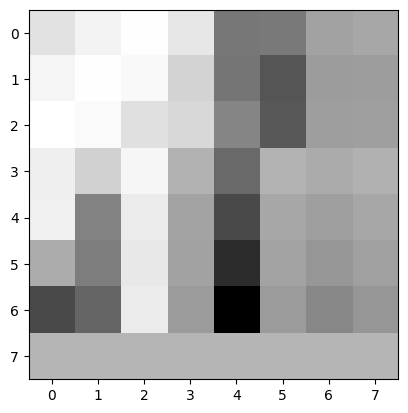

In [15]:
print("data after inverse dct:\n", np.round(inverse_dct,2))

fig, ax = plt.subplots()
ax.imshow(inverse_dct, cmap="gray")
plt.show()

data after inverse dct (rounded to int & clipped to range 0..255):
 [[153. 162. 167. 155.  94.  95. 118. 120.]
 [163. 167. 165. 145.  93.  76. 114. 115.]
 [168. 165. 151. 147. 102.  78. 115. 116.]
 [160. 143. 163. 126.  87. 127. 122. 126.]
 [160. 100. 157. 119.  69. 121. 116. 120.]
 [123.  98. 156. 118.  54. 118. 111. 117.]
 [ 70.  85. 157. 114.  30. 114. 103. 111.]
 [128. 128. 128. 128. 128. 128. 128. 128.]]


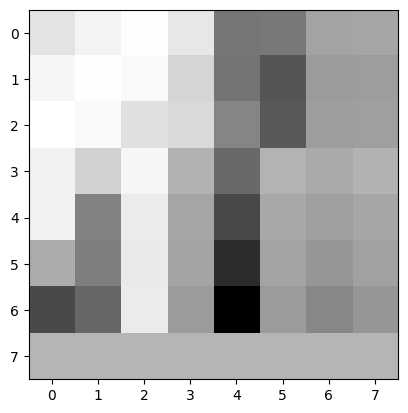

In [16]:
inverse_dct_ints = np.clip(np.rint(inverse_dct), a_min=0, a_max=255)
print("data after inverse dct (rounded to int & clipped to range 0..255):\n", np.round(inverse_dct_ints,2))

fig, ax = plt.subplots()
ax.imshow(inverse_dct_ints, cmap="gray")
plt.show()

original_image:
 [[158 156 165 147  98 106 110 124]
 [157 159 164 144  95 105 108 122]
 [161 163 161 142  94 104 108 121]
 [165 139 161 145  90 101 108 121]
 [152 106 164 142  85 100 105 116]
 [109 105 164 141  87 100 105 117]
 [ 91 105 162 142  86  99 104 116]
 [ 91 103 161 142  83  98 104 122]]


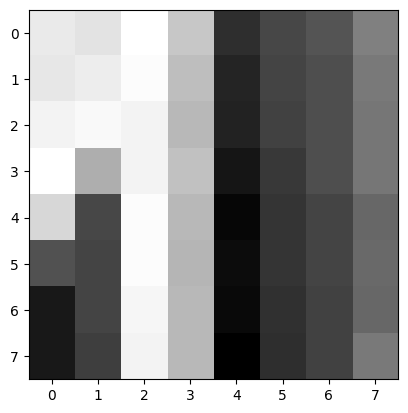

In [17]:
# just for comparison print again
print("original_image:\n",original_image)
fig, ax = plt.subplots()
ax.imshow(original_image, cmap="gray")
plt.show()